In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


In [3]:
adata_pb = sc.read('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/pb_adata_MG_sep.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 292 × 29040
    obs: 'sample', 'sample_lesion', 'diagnosis', 'sample_source', 'cell_type', 'sample_rep', 'replicate_cat', 'stim', 'sex', 'seq_pool', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'batch', 'lib_size', 'log_lib_size'
    uns: 'age_cat_colors', 'cell_type_colors', 'diagnosis_colors', 'log1p', 'pca', 'pmi_cat2_colors', 'pmi_cat_colors', 'sample_source_colors', 'seq_pool_colors', 'sex_colors', 'stim_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

# Identify outliers

In [4]:
adata_pb.obs['cell_stim'] = adata_pb.obs['cell_type'].astype(str) + '_' + adata_pb.obs['stim'].astype(str)

In [5]:
# Extract the log_lib_size column
log_lib_size = adata_pb.obs['log_lib_size']

# Compute the median
median = np.median(log_lib_size)

# Compute the MAD (Median Absolute Deviation)
mad = np.median(np.abs(log_lib_size - median))

# Define the upper and lower thresholds
upper_threshold = median + 3 * mad
lower_threshold = median - 3 * mad

# Find outliers
outliers = adata_pb.obs[(log_lib_size < lower_threshold)]

# Print the results
print(f"Median: {median}, MAD: {mad}")
print(f"Lower threshold: {lower_threshold}")
print(f"Outliers:\n{outliers}")

Median: 12.186070736808462, MAD: 0.8403393485043571
Lower threshold: 9.66505269129539
Outliers:
                                            sample       sample_lesion  \
donor_Ind120-Sample1_0-0-0-0-0-0-0  Ind120-Sample1  Ind120-Sample1_CAL   
donor_Ind143-Sample1_0-1-0-0        Ind143-Sample1   Ind143-Sample1_AL   

                                   diagnosis sample_source cell_type  \
donor_Ind120-Sample1_0-0-0-0-0-0-0      SPMS  Amsterdam BB      Mg_A   
donor_Ind143-Sample1_0-1-0-0            PPMS  Amsterdam BB      Mg_E   

                                   sample_rep replicate_cat stim sex seq_pool  \
donor_Ind120-Sample1_0-0-0-0-0-0-0      CAL_5             5  CAL   M   Pool 1   
donor_Ind143-Sample1_0-1-0-0            AL_20            20   AL   M   Pool 1   

                                   age_scale   age_cat    pmi_cat   pmi_cat2  \
donor_Ind120-Sample1_0-0-0-0-0-0-0  0.713744   over_70  6H_to_12H  up_to_12H   
donor_Ind143-Sample1_0-1-0-0       -1.141343  under_50  6H_t

In [6]:
# Compute the max and min log_lib_size
max_log_lib_size = log_lib_size.max()
min_log_lib_size = log_lib_size.min()

print(f"Maximum log_lib_size: {max_log_lib_size}")
print(f"Minimum log_lib_size: {min_log_lib_size}")

Maximum log_lib_size: 15.242901515897758
Minimum log_lib_size: 9.490620114661201


In [7]:
print(f"All samples: {adata_pb.shape[0]}")

All samples: 292


In [8]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,CAL,CIL,NAWM,RL,WM
cell_type,,,,,,
Mg_A,13,7,5,8,5,9
Mg_B,12,7,10,12,9,11
Mg_C,13,11,8,9,7,6
Mg_D,11,7,4,7,3,0
Mg_E,14,13,8,7,4,2
Mg_F,6,7,5,7,5,4
Mg_G,5,3,2,2,4,0


In [9]:
# Define the list of samples to remove
samples_to_remove = [
    "donor_Ind120-Sample1_0-0-0-0-0-0-0",
    "donor_Ind143-Sample1_0-1-0-0"
]

# Filter out the samples to remove
adata_pb = adata_pb[~adata_pb.obs.index.isin(samples_to_remove)].copy()

# Confirm removal
print(f"Remaining samples: {adata_pb.shape[0]}")

Remaining samples: 290


# Subset to relevant comparison 

In [10]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,CAL,CIL,NAWM,RL,WM
cell_type,,,,,,
Mg_A,13,6,5,8,5,9
Mg_B,12,7,10,12,9,11
Mg_C,13,11,8,9,7,6
Mg_D,11,7,4,7,3,0
Mg_E,13,13,8,7,4,2
Mg_F,6,7,5,7,5,4
Mg_G,5,3,2,2,4,0


In [13]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['Mg_A', 'Mg_F'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (80, 29040)


In [14]:
adata_sub.obs

,sample,sample_lesion,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim
donor_Ind98-Sample2_0-0-0-0-0-0-0,Ind98-Sample2,Ind98-Sample2_WM,CTR,Edinburgh BB,Mg_A,WM_1,1,WM,M,Pool 6,-1.759706,under_50,over_12H,over_12H,0,268489,12.500565,Mg_A_WM
donor_Ind102-Sample1_0-0-0-0-0-0-0,Ind102-Sample1,Ind102-Sample1_AL,SPMS,Amsterdam BB,Mg_A,AL_1,1,AL,M,Pool 4,0.301502,inbetween,6H_to_12H,up_to_12H,0,66310,11.102096,Mg_A_AL
donor_Ind102-Sample4_0-0-0-0-0-0-0,Ind102-Sample4,Ind102-Sample4_CAL,SPMS,Amsterdam BB,Mg_A,CAL_17,17,CAL,M,Pool 1,0.301502,inbetween,6H_to_12H,up_to_12H,0,40936,10.619765,Mg_A_CAL
donor_Ind103-Sample1_0-0-0-0-0-0-0,Ind103-Sample1,Ind103-Sample1_AL,RRMS,Amsterdam BB,Mg_A,AL_2,2,AL,F,Pool 3,-1.484878,under_50,up_to_6H,up_to_12H,0,143763,11.875921,Mg_A_AL
donor_Ind104-Sample1_0-0-0-0-0-0-0,Ind104-Sample1,Ind104-Sample1_RL,SPMS,UK MS TB,Mg_A,RL_2,2,RL,F,Pool 5,0.645037,inbetween,over_12H,over_12H,0,35938,10.489551,Mg_A_RL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
donor_Ind136-Sample1_0-1-0,Ind136-Sample1,Ind136-Sample1_CAL,PPMS,Amsterdam BB,Mg_F,CAL_14,14,CAL,M,Pool 3,-1.278757,under_50,6H_to_12H,up_to_12H,0,189816,12.153810,Mg_F_CAL
donor_Ind137-Sample1_0-1-0,Ind137-Sample1,Ind137-Sample1_CAL,SPMS,Amsterdam BB,Mg_F,CAL_15,15,CAL,M,Pool 2,-0.935223,under_50,up_to_6H,up_to_12H,0,198185,12.196956,Mg_F_CAL
donor_Ind141-Sample2_0-1-0,Ind141-Sample2,Ind141-Sample2_RL,SPMS,Amsterdam BB,Mg_F,RL_8,8,RL,M,Pool 1,0.507623,inbetween,6H_to_12H,up_to_12H,0,138932,11.841740,Mg_F_RL
donor_Ind144-Sample1_0-1-0,Ind144-Sample1,Ind144-Sample1_WM,CTR,Amsterdam BB,Mg_F,WM_12,12,WM,M,Pool 1,1.744348,over_70,up_to_6H,up_to_12H,0,1762671,14.382341,Mg_F_WM


In [15]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['stim'].unique()
for condition in unique_conditions:
    print(condition)

WM
AL
CAL
RL
CIL
NAWM


In [16]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['stim'], 
                           ['WM',
                              'RL'
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (23, 29040)


In [17]:
# Check if the 'sample_rep' column exists
if 'sample_lesion' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_lesion', inplace=True)
else:
    print("The column 'sample' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [18]:
# Add the index back as a column called 'sample_lesion'
adata_sub.obs['sample_lesion'] = adata_sub.obs.index

In [19]:
adata_sub.obs['indiv_id'] = adata_sub.obs['sample'].str.split('-').str[0]
adata_sub.obs[:5]

,sample,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim,sample_lesion,indiv_id
Ind98-Sample2_WM,Ind98-Sample2,CTR,Edinburgh BB,Mg_A,WM_1,1,WM,M,Pool 6,-1.759706,under_50,over_12H,over_12H,0,268489,12.500565,Mg_A_WM,Ind98-Sample2_WM,Ind98
Ind104-Sample1_RL,Ind104-Sample1,SPMS,UK MS TB,Mg_A,RL_2,2,RL,F,Pool 5,0.645037,inbetween,over_12H,over_12H,0,35938,10.489551,Mg_A_RL,Ind104-Sample1_RL,Ind104
Ind107-Sample1_WM,Ind107-Sample1,CTR,Edinburgh BB,Mg_A,WM_3,3,WM,M,Pool 3,-0.935223,under_50,over_12H,over_12H,0,706855,13.468581,Mg_A_WM,Ind107-Sample1_WM,Ind107
Ind108-Sample3_RL,Ind108-Sample3,SPMS,UK MS TB,Mg_A,RL_3,3,RL,F,Pool 6,-0.866516,under_50,6H_to_12H,up_to_12H,0,50476,10.829253,Mg_A_RL,Ind108-Sample3_RL,Ind108
Ind117-Sample1_WM,Ind117-Sample1,CTR,Edinburgh BB,Mg_A,WM_4,4,WM,F,Pool 4,-0.935223,under_50,over_12H,over_12H,0,1079993,13.892465,Mg_A_WM,Ind117-Sample1_WM,Ind117


In [20]:
# Extract the data as a pandas DataFrame
df = adata_sub.obs[['cell_stim', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_stim', 'stim']).size().unstack(fill_value=0)
summary_table

stim,RL,WM
cell_stim,,
Mg_A_RL,5,0
Mg_A_WM,0,9
Mg_F_RL,5,0
Mg_F_WM,0,4


In [21]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_stim'], 
                           ['Mg_A_WM',
                            'Mg_F_RL'
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (14, 29040)


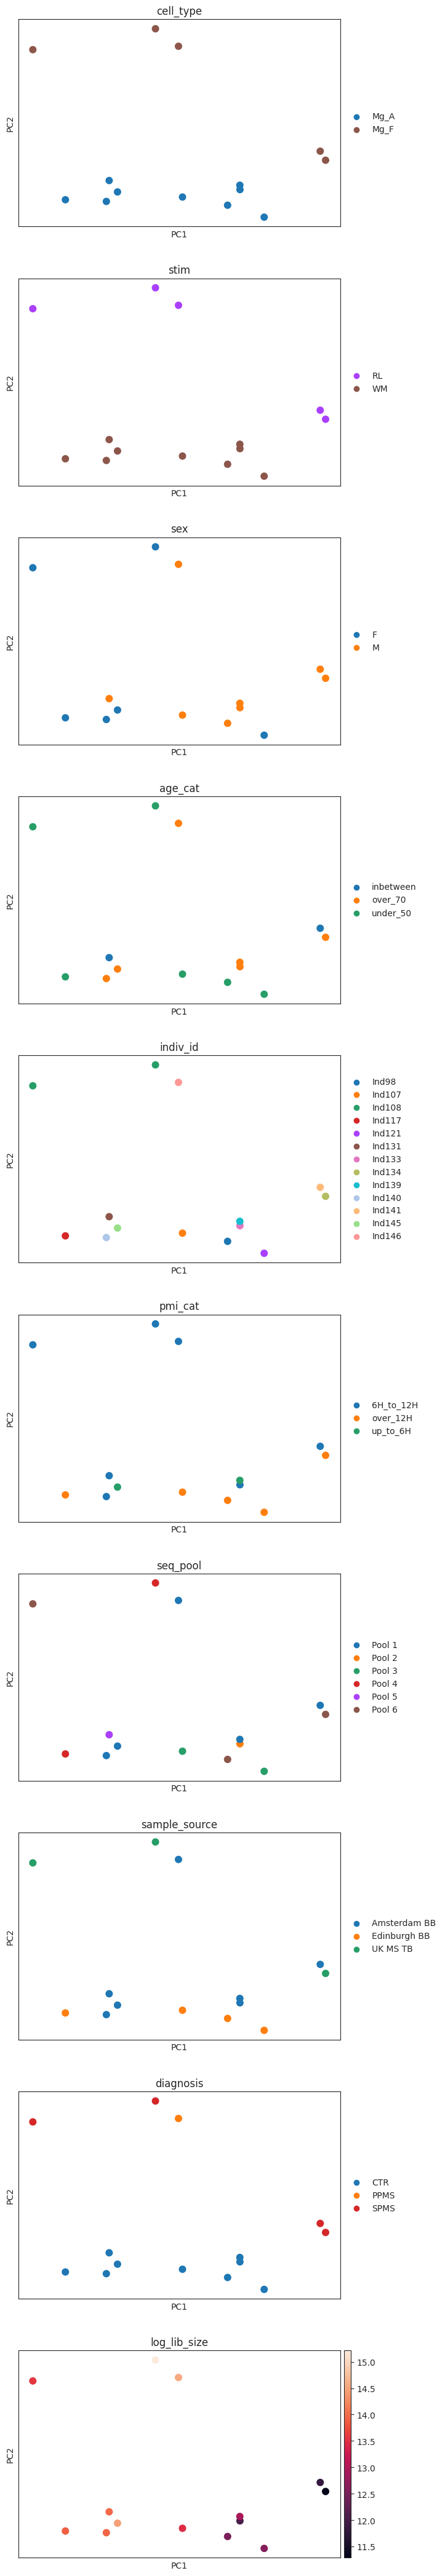

In [22]:
sc.pl.pca(adata_sub, color=["cell_type", "stim", "sex", "age_cat", "indiv_id",
                            "pmi_cat", "seq_pool", "sample_source", "diagnosis", "log_lib_size"], 
          ncols=1, size=300)

In [23]:
# Replace space with underscore in the 'seq_pool' column
adata_sub.obs['seq_pool'] = adata_sub.obs['seq_pool'].str.replace(' ', '_')
adata_sub.obs[:5]

,sample,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim,sample_lesion,indiv_id
Ind98-Sample2_WM,Ind98-Sample2,CTR,Edinburgh BB,Mg_A,WM_1,1,WM,M,Pool_6,-1.759706,under_50,over_12H,over_12H,0,268489,12.500565,Mg_A_WM,Ind98-Sample2_WM,Ind98
Ind107-Sample1_WM,Ind107-Sample1,CTR,Edinburgh BB,Mg_A,WM_3,3,WM,M,Pool_3,-0.935223,under_50,over_12H,over_12H,0,706855,13.468581,Mg_A_WM,Ind107-Sample1_WM,Ind107
Ind117-Sample1_WM,Ind117-Sample1,CTR,Edinburgh BB,Mg_A,WM_4,4,WM,F,Pool_4,-0.935223,under_50,over_12H,over_12H,0,1079993,13.892465,Mg_A_WM,Ind117-Sample1_WM,Ind117
Ind121-Sample1_WM,Ind121-Sample1,CTR,Edinburgh BB,Mg_A,WM_5,5,WM,F,Pool_3,-0.729102,under_50,over_12H,over_12H,0,297926,12.604600,Mg_A_WM,Ind121-Sample1_WM,Ind121
Ind131-Sample1_WM,Ind131-Sample1,CTR,Amsterdam BB,Mg_A,WM_7,7,WM,M,Pool_5,0.438916,inbetween,6H_to_12H,up_to_12H,0,1178400,13.979668,Mg_A_WM,Ind131-Sample1_WM,Ind131


In [24]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[ 2  1  0  0  6]
 [12  0  0  0 40]
 [ 7  0  0  0 41]
 [ 2  0  0  0 10]
 [ 4  0  1  0 23]]


In [25]:
# Extract the data as a pandas DataFrame
df = adata_sub.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,RL,WM
cell_type,,
Mg_A,0,9
Mg_F,5,0


# Start R code: QC of log transformation

In [26]:
for col in adata_sub.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_sub.obs[col]):
        adata_sub.obs[col] = adata_sub.obs[col].astype(str)

In [27]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$stim #ctrl or stim
replicate <- colData(adata_sub)$replicate_cat #replicate number
batch <- colData(adata_sub)$sample_lesion #this is each indiv sample

# Concatenate label and cell type for group factor
sex <- colData(adata_sub)$sex #ctrl or stim
age_cat <- colData(adata_sub)$age_cat #replicate number
pmi_cat <- colData(adata_sub)$pmi_cat #this is each indiv sample
pmi_cat2 <- colData(adata_sub)$pmi_cat2 #replicate number
seq_pool <- colData(adata_sub)$seq_pool #this is each indiv sample

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"=batch,
                        "Sex"=sex, "Age_cat"=age_cat, "Pmi_cat"=pmi_cat, "Pmi_cat2"=pmi_cat2,
                        "Seq_pool"=seq_pool)
head(treatments)

                  Group Reps             Batch Sex   Age_cat   Pmi_cat
Ind98-Sample2_WM     WM    1  Ind98-Sample2_WM   M  under_50  over_12H
Ind107-Sample1_WM    WM    3 Ind107-Sample1_WM   M  under_50  over_12H
Ind117-Sample1_WM    WM    4 Ind117-Sample1_WM   F  under_50  over_12H
Ind121-Sample1_WM    WM    5 Ind121-Sample1_WM   F  under_50  over_12H
Ind131-Sample1_WM    WM    7 Ind131-Sample1_WM   M inbetween 6H_to_12H
Ind133-Sample1_WM    WM    8 Ind133-Sample1_WM   M   over_70 6H_to_12H
                   Pmi_cat2 Seq_pool
Ind98-Sample2_WM   over_12H   Pool_6
Ind107-Sample1_WM  over_12H   Pool_3
Ind117-Sample1_WM  over_12H   Pool_4
Ind121-Sample1_WM  over_12H   Pool_3
Ind131-Sample1_WM up_to_12H   Pool_5
Ind133-Sample1_WM up_to_12H   Pool_2


In [28]:
%%R -i adata_sub

# Create the treatments dataframe with samples as a column, not as row names
treatments <- data.frame(
  #Sample = colData(adata_sub)$sample,      # Sample column
  Group = colData(adata_sub)$stim,        # Group (e.g., ctrl or stim)
  Donor = colData(adata_sub)$indiv_id,    # Donor information
  Sex = colData(adata_sub)$sex,           # Sex information
  Age_cat = colData(adata_sub)$age_cat,   # Age category
  Pmi_cat = colData(adata_sub)$pmi_cat   # Post-mortem interval category
)

# Check the updated dataframe to confirm
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind131-Sample1_WM    WM Ind131   M inbetween 6H_to_12H
Ind133-Sample1_WM    WM Ind133   M   over_70 6H_to_12H


In [29]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$stim)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 29040    14

RL WM 
 5  9 


In [30]:
%%R

# Adjust for batch-- ie publication in the model matrix
design_full <- model.matrix(~0 + Group + Sex + Age_cat + Pmi_cat, data=treatments)
rownames(design_full) <- colnames(x)
colnames(design_full)

[1] "GroupRL"         "GroupWM"         "SexM"            "Age_catover_70" 
[5] "Age_catunder_50" "Pmi_catover_12H" "Pmi_catup_to_6H"


In [31]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design_full)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 10168    14


In [32]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 11492    14


In [33]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 1.0169902 0.9869880 1.0372714 1.0475174 0.9786522 1.0500509 0.9916548
 [8] 1.0498323 0.9951253 0.9911114 0.8714620 1.2207049 1.0323222 0.7912685


In [34]:
%%R
cd <- x2$samples$group
print(cd)

 [1] WM WM WM WM WM WM WM WM WM RL RL RL RL RL
Levels: RL WM


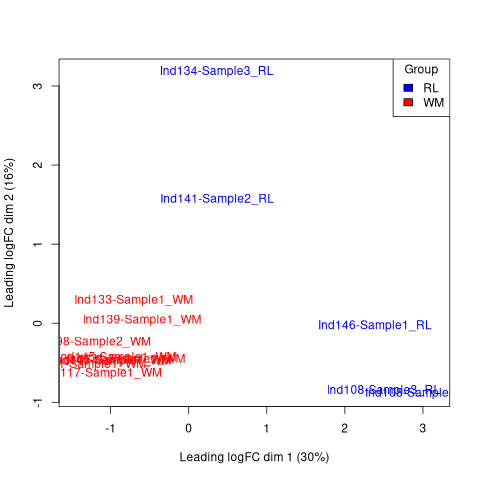

In [35]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

# Voom with quality weights- sex, age, pmi, seq_pool

In [36]:
%%R
donor <- colData(adata_sub)$indiv_id #this is each indiv sample
donor

 Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM Ind121-Sample1_WM 
          "Ind98"          "Ind107"          "Ind117"          "Ind121" 
Ind131-Sample1_WM Ind133-Sample1_WM Ind139-Sample1_WM Ind140-Sample1_WM 
         "Ind131"          "Ind133"          "Ind139"          "Ind140" 
Ind145-Sample1_WM Ind108-Sample3_RL Ind108-Sample4_RL Ind134-Sample3_RL 
         "Ind145"          "Ind108"          "Ind108"          "Ind134" 
Ind141-Sample2_RL Ind146-Sample1_RL 
         "Ind141"          "Ind146" 


In [37]:
%%R
head(design_full)

                  GroupRL GroupWM SexM Age_catover_70 Age_catunder_50
Ind98-Sample2_WM        0       1    1              0               1
Ind107-Sample1_WM       0       1    1              0               1
Ind117-Sample1_WM       0       1    0              0               1
Ind121-Sample1_WM       0       1    0              0               1
Ind131-Sample1_WM       0       1    1              0               0
Ind133-Sample1_WM       0       1    1              1               0
                  Pmi_catover_12H Pmi_catup_to_6H
Ind98-Sample2_WM                1               0
Ind107-Sample1_WM               1               0
Ind117-Sample1_WM               1               0
Ind121-Sample1_WM               1               0
Ind131-Sample1_WM               0               0
Ind133-Sample1_WM               0               0


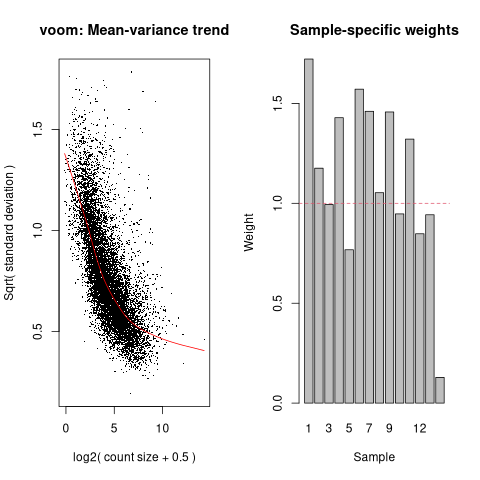

In [38]:
%%R

y_vqw_full <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE)

In [39]:
%%R

corfit <- duplicateCorrelation(y_vqw_full, design_full, block=donor)
corfit$consensus.correlation

[1] NaN


In [41]:
%%R

y2 <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE, block=donor, correlation=corfit$consensus)

Error in if (abs(correlation) >= 1) stop("correlation is 1 or -1, so the model is degenerate") : 
  missing value where TRUE/FALSE needed


RInterpreterError: Failed to parse and evaluate line '\ny2 <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE, block=donor)\n'.
R error message: 'Error in if (abs(correlation) >= 1) stop("correlation is 1 or -1, so the model is degenerate") : \n  missing value where TRUE/FALSE needed'

In [ ]:
%%R

corfit2 <- duplicateCorrelation(y2, design_full, block=donor)
corfit2$consensus.correlation

In [43]:
%%R

fit <- lmFit(y_vqw_full, design_full)

In [44]:
%%R

contr <- makeContrasts(GroupRL - GroupWM, levels = colnames(coef(fit)))

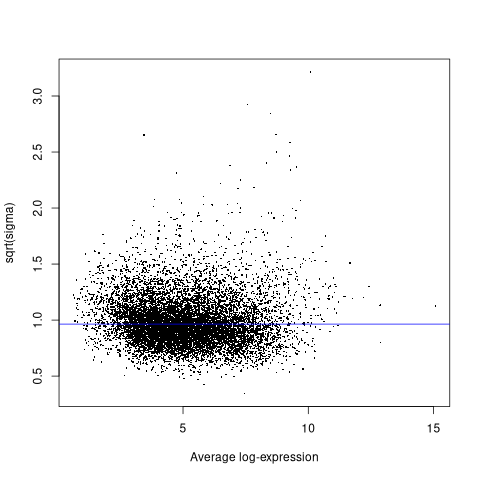

In [45]:
%%R

tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [46]:
%%R

# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

             logFC   AveExpr         t      P.Value    adj.P.Val         B
IQGAP2    3.560235  6.749589  13.90817 2.431793e-09 1.422211e-05 11.801315
DPYD      2.881384  8.489363  13.75400 2.797425e-09 1.422211e-05 11.805865
DSCAM    -2.482605  9.821328 -12.81088 6.798148e-09 1.973768e-05 10.901352
SYNDIG1  -3.779564 10.256348 -12.67463 7.764626e-09 1.973768e-05 10.778170
RASGEF1C -3.264925  9.288228 -12.18168 1.269119e-08 2.286386e-05 10.305131
TGFBI     7.395977  3.187120  12.05513 1.443641e-08 2.286386e-05  7.479511
XACT     -4.512318  8.282735 -11.97083 1.574027e-08 2.286386e-05 10.069931
CDK14     5.351115  4.628761  11.64376 2.212297e-08 2.532763e-05  9.028765
RASSF8   -2.104363  8.904391 -11.47548 2.643995e-08 2.532763e-05  9.578652
IL6ST    -1.651479  8.882682 -11.43595 2.757924e-08 2.532763e-05  9.525828


In [47]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 1126


In [48]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 455
            logFC  AveExpr         t      P.Value    adj.P.Val           B
CD163    8.225817 3.218087  9.790716 1.790670e-07 8.670256e-05  6.04547555
TGFBI    7.395977 3.187120 12.055132 1.443641e-08 2.286386e-05  7.47951052
SLC16A10 6.679153 2.778463  4.447215 6.140047e-04 1.214630e-02 -0.50640413
F13A1    6.591577 2.628827  8.058245 1.701096e-06 2.886165e-04  4.38551109
ST18     6.396968 3.661422  6.917800 9.049185e-06 8.215367e-04  3.14212123
GFAP     6.033948 2.389294  4.943476 2.464541e-04 6.682522e-03  0.06976868


In [49]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 439
               logFC  AveExpr         t      P.Value    adj.P.Val          B
AC008691.1 -6.597740 7.774664 -7.597085 3.278855e-06 0.0004471427  4.5083009
AP003481.1 -6.235006 7.064962 -7.240857 5.542563e-06 0.0006059869  3.9629279
HCG22      -5.601553 4.708839 -4.167004 1.040989e-03 0.0169356477 -0.5742225
MORC1      -5.263832 4.273531 -7.425057 4.216469e-06 0.0005103935  3.6999861
ELAVL4     -5.111999 3.895343 -5.297064 1.311038e-04 0.0043625534  1.0514046
ZNF608     -4.891634 4.400502 -7.661080 2.988814e-06 0.0004163050  4.1323603


## Voom by group

Group:
1 RL 
2 WM 


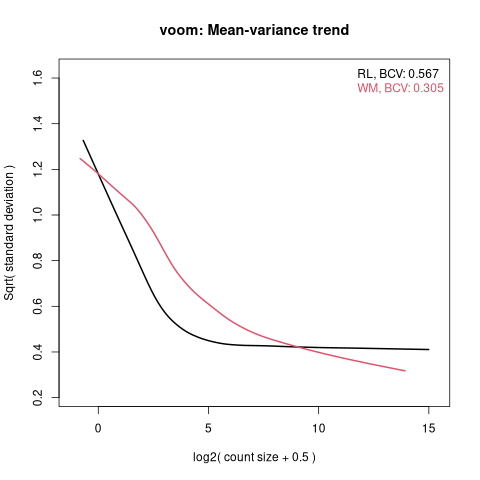

In [50]:
%%R
source("/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/MM_sysVI/voomByGroup.R")
y_vbg <- voomByGroup(x2,design = design_full, group = cd, plot = "combine")

In [51]:
%%R
fit <- lmFit(y_vbg, design_full)

In [52]:
%%R
contr <- makeContrasts(GroupRL - GroupWM, levels = colnames(coef(fit)))

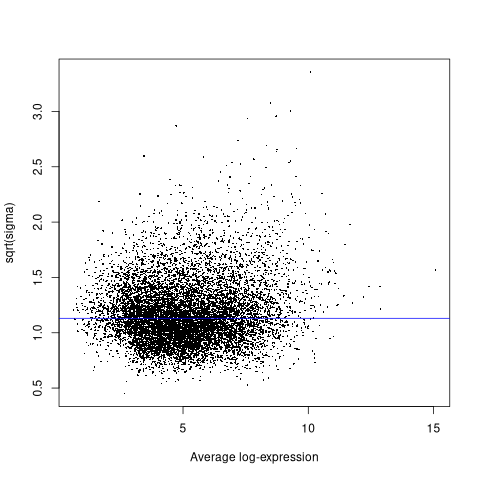

In [53]:
%%R
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [54]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_full[tt_full$adj.P.Val < 0.05 & tt_full$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 459
            logFC  AveExpr         t      P.Value    adj.P.Val          B
CD163    8.082447 3.218087  7.524770 6.649977e-06 7.193295e-04  2.9085598
TGFBI    7.459336 3.187120 10.903244 1.288074e-07 6.585345e-05  5.4141617
SLC16A10 6.659466 2.778463  3.665754 3.188027e-03 3.666952e-02 -1.9097683
GFAP     6.245483 2.389294  4.655787 5.424211e-04 1.238475e-02 -0.7411093
F13A1    6.218764 2.628827  6.804380 1.809605e-05 1.314290e-03  2.2669819
ST18     6.193258 3.661423  6.349718 3.523760e-05 1.979535e-03  2.0277750


In [55]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_full[tt_full$adj.P.Val < 0.05 & tt_full$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 343
               logFC  AveExpr          t      P.Value    adj.P.Val          B
AC008691.1 -5.732261 7.774665 -13.619440 1.054672e-08 1.848233e-05 10.5427240
HCG22      -5.509694 4.708840  -4.405839 8.393248e-04 1.603035e-02 -0.4759507
AL445623.2 -5.086301 3.713268  -5.251368 1.981950e-04 6.362796e-03  0.6347901
AP003481.1 -5.068523 7.064962 -13.887463 8.441144e-09 1.848233e-05 10.7003560
MORC1      -4.743898 4.273531  -9.381622 6.639014e-07 1.776460e-04  5.4308478
VWC2       -4.720811 3.677494  -4.280986 1.046878e-03 1.803027e-02 -0.6171760


### Save output

In [56]:
%%R

head(tt)

             logFC   AveExpr         t      P.Value    adj.P.Val         B
IQGAP2    3.560235  6.749589  13.90817 2.431793e-09 1.422211e-05 11.801315
DPYD      2.881384  8.489363  13.75400 2.797425e-09 1.422211e-05 11.805865
DSCAM    -2.482605  9.821328 -12.81088 6.798148e-09 1.973768e-05 10.901352
SYNDIG1  -3.779564 10.256348 -12.67463 7.764626e-09 1.973768e-05 10.778170
RASGEF1C -3.264925  9.288228 -12.18168 1.269119e-08 2.286386e-05 10.305131
TGFBI     7.395977  3.187120  12.05513 1.443641e-08 2.286386e-05  7.479511


In [57]:
%%R

# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/MG_FvA_WM_v_RL_vwqw_blocked.csv", row.names = FALSE, sep = ",", quote = FALSE)

In [58]:
%%R

head(tt_full)

               logFC  AveExpr         t      P.Value    adj.P.Val        B
RASGEF1C   -3.247071 9.288229 -17.09514 7.648567e-10 7.777063e-06 13.14731
IQGAP2      3.419944 6.749590  14.36939 5.709666e-09 1.848233e-05 10.96222
AP003481.1 -5.068523 7.064962 -13.88746 8.441144e-09 1.848233e-05 10.70036
AC008691.1 -5.732261 7.774665 -13.61944 1.054672e-08 1.848233e-05 10.54272
DPYD        2.843910 8.489363  13.48466 1.181383e-08 1.848233e-05 10.45176
KCNIP1     -3.664344 8.321397 -13.46687 1.199308e-08 1.848233e-05 10.44048


In [59]:
%%R

# Add row names as a new column
tt_full$gene <- rownames(tt_full)

# Optionally reorder or select columns
tt_full <- tt_full[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt_full, file = "./files/MG_FvA_WM_v_RL_bygroup.csv", row.names = FALSE, sep = ",", quote = FALSE)

# Dream analysis

In [63]:
%%R

library("variancePartition")
library("BiocParallel")

Loading required package: ggplot2
Loading required package: BiocParallel

Attaching package: ‘variancePartition’

The following object is masked from ‘package:limma’:

    topTable



In [60]:
%%R

options(ports=8889)

In [64]:
%%R

param <- SnowParam(4, "SOCK", progressbar = TRUE)

In [65]:
%%R
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind131-Sample1_WM    WM Ind131   M inbetween 6H_to_12H
Ind133-Sample1_WM    WM Ind133   M   over_70 6H_to_12H


In [66]:
%%R

# Convert Group column to a factor
treatments$Group <- factor(treatments$Group)

# Check levels to confirm AL and WM exist
levels(treatments$Group)

[1] "RL" "WM"


In [67]:
%%R

form <- ~ Group + (1 | Donor)

In [69]:
%%R

vobjDream <- voomWithDreamWeights(x2, form, treatments)

In [70]:
%%R

fitmm <- dream(vobjDream, form, treatments)
fitmm <- eBayes(fitmm)

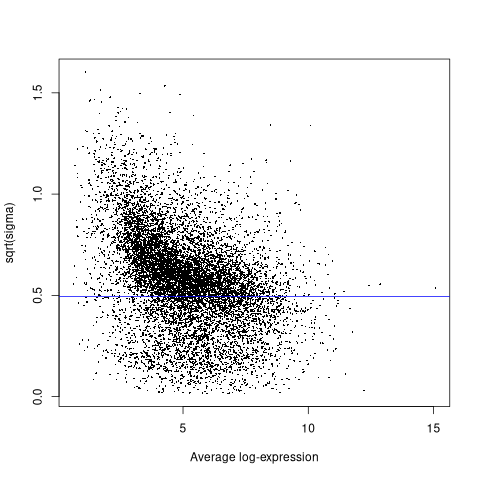

In [71]:
%%R

plotSA(fitmm, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [72]:
%%R

head(fitmm$design, 5)

                  (Intercept) GroupWM
Ind98-Sample2_WM            1       1
Ind107-Sample1_WM           1       1
Ind117-Sample1_WM           1       1
Ind121-Sample1_WM           1       1
Ind131-Sample1_WM           1       1


In [73]:
%%R

tt_dream <- topTable(fitmm, sort.by = "P", n = Inf)

Removing intercept from test coefficients


In [74]:
%%R
length(which(tt_dream$adj.P.Val < 0.05))

[1] 1591


In [89]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC <= 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 1022
             gene      logFC  AveExpr          t      P.Value    adj.P.Val
SLC16A10 SLC16A10 -10.285514 2.778463  -8.634169 6.064820e-07 2.792234e-04
AREG         AREG  -8.408036 1.962417  -7.554457 1.088199e-05 1.117657e-03
TGFBI       TGFBI  -7.448151 3.187120 -12.125474 1.838235e-08 3.441108e-05
CD163       CD163  -7.202863 3.218087  -6.478642 3.689246e-05 2.380161e-03
ADM           ADM  -7.088885 1.591672  -7.792087 1.990833e-06 4.778233e-04
SH3BP5     SH3BP5  -7.062426 2.389715  -7.141174 6.843476e-06 8.383671e-04
                 B     z.std   gene.1
SLC16A10 6.0885394 -4.989142 SLC16A10
AREG     4.0236909 -4.398862     AREG
TGFBI    3.4135712 -5.626574    TGFBI
CD163    0.2796263 -4.126126    CD163
ADM      5.2714459 -4.754353      ADM
SH3BP5   3.9917851 -4.498499   SH3BP5


In [76]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC >= -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 621
            logFC  AveExpr         t     P.Value  adj.P.Val          B
MTCH2  -0.6986076 5.724695 -3.737190 0.004636798 0.03651095 -1.7569613
CEP57  -0.6978689 6.325701 -3.964417 0.003018162 0.02826615 -1.3224961
SRSF10 -0.6975919 6.532828 -4.198195 0.002325687 0.02460456 -0.8600241
HAUS2  -0.6965037 4.179547 -3.446619 0.005190197 0.03889014 -2.3917245
EIF4H  -0.6919797 5.804500 -3.627860 0.004858919 0.03742840 -1.9865646
PAXX   -0.6851825 4.701461 -3.457917 0.006797387 0.04595184 -2.6363915
           z.std
MTCH2  -2.831240
CEP57  -2.965882
SRSF10 -3.045144
HAUS2  -2.794986
EIF4H  -2.816241
PAXX   -2.706611


In [77]:
%%R

# Add row names as a new column
tt_dream$gene <- rownames(tt_dream)

In [78]:
%%R
head(tt_dream)

            logFC  AveExpr         t      P.Value    adj.P.Val         B
PLXNC1  -4.977773 4.649426 -16.25569 2.048165e-10 2.082574e-06 14.083097
EMILIN2 -4.500667 2.496653 -13.67313 1.970558e-09 8.211570e-06 11.794060
PTPN22  -4.157709 3.407846 -13.45659 2.422768e-09 8.211570e-06 11.794833
ATP6AP2 -1.921152 5.251481 -14.62884 7.633830e-09 1.940519e-05 12.875851
TGFBI   -7.448151 3.187120 -12.12547 1.838235e-08 3.441108e-05  3.413571
LDLRAD3 -4.129834 3.491407 -11.25580 2.364878e-08 3.441108e-05  9.642147
            z.std    gene
PLXNC1  -6.357685  PLXNC1
EMILIN2 -6.000215 EMILIN2
PTPN22  -5.966581  PTPN22
ATP6AP2 -5.776350 ATP6AP2
TGFBI   -5.626574   TGFBI
LDLRAD3 -5.582939 LDLRAD3


In [79]:
%%R

# Optionally reorder or select columns
tt_dream <- tt_dream[, c("gene", names(tt_dream)[1:8])]

# Write to CSV file
write.table(tt_dream, file = "./files/MG_FvA_WM_v_RL_dream.csv", row.names = FALSE, sep = ",", quote = FALSE)

## Dream with added variables

In [ ]:
%%R
colnames(treatments)

In [ ]:
%%R

form <- ~ 0 + Group + Sex + Age_cat + Pmi_cat + (1 | Donor)

In [ ]:
%%R

L <- makeContrastsDream(form, treatments,
  contrasts = c(
    compare1 = "GroupRL - GroupWM"
  )
)

# Visualize contrast matrix
plotContrasts(L)

In [ ]:
%%R

vobjDream2 <- voomWithDreamWeights(x2, form, treatments, BPPARAM = param)

In [ ]:
%%R

# fit dream model with contrasts
fit_full <- dream(vobjDream2, form, treatments, L)
fit_full <- eBayes(fit_full)

# get names of available coefficients and contrasts for testing
colnames(fit_full)

In [ ]:
%%R

tt_dream_full <- topTable(fit_full, coef="compare1", sort.by = "P", n = Inf)

In [ ]:
%%R

length(which(tt_dream_full$adj.P.Val < 0.05))

In [ ]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC > 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

In [ ]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC < -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

### Variance partition plots

In [ ]:
%%R

form <- ~ (1 | Group) + (1 | Sex) + (1 | Donor)
vp <- fitExtractVarPartModel(y2, form, treatments)

plotVarPart(sortCols(vp))

In [ ]:
%%R

form <- ~ (1 | Group) + (1 | Sex) + (1 | Age_cat) + (1 | Pmi_cat) + (1 | Donor)
vp <- fitExtractVarPartModel(y2, form, treatments)

plotVarPart(sortCols(vp))

In [ ]:
%%R

# Compare p-values and make plot
p1 <- topTable(tmp2, coef = "GroupRL - GroupWM", number = Inf, sort.by = "none")$P.Value
p2 <- topTable(fitmm, number = Inf, sort.by = "none")$P.Value

plotCompareP(p1, p2, vp$Donor, corfit2$consensus)

# Box plots of highly differentially expressed genes

In [81]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [82]:
%%R
library(reshape2)  # For transforming data from wide to long format
library(ggplot2)   # For plotting

# Step 1: Combine Expression and Treatment Data
# Convert the E matrix into a dataframe
expr_df <- as.data.frame(cpm)
expr_df$gene <- rownames(cpm)  # Add gene names as a column

head(expr_df)

           Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM
AL627309.1         7.462282         17.506663          6.363466
AL669831.5        22.386845         58.355544         37.271731
LINC00115         11.193422          4.376666          2.727200
NOC2L             14.924563         17.506663         21.817599
C1orf159          29.849127         51.061101         28.181065
SDF4              26.117986         26.259995         31.817331
           Ind121-Sample1_WM Ind131-Sample1_WM Ind133-Sample1_WM
AL627309.1          6.520151          3.526316         11.404729
AL669831.5         32.600753         20.276316         11.404729
LINC00115           0.000000          1.763158          5.702365
NOC2L              16.300376         24.684211         11.404729
C1orf159           22.820527         11.460527         22.809458
SDF4               13.040301         28.210527         28.511823
           Ind139-Sample1_WM Ind140-Sample1_WM Ind145-Sample1_WM
AL627309.1          9.951869    

In [83]:
%%R
colnames(expr_df)

 [1] "Ind98-Sample2_WM"  "Ind107-Sample1_WM" "Ind117-Sample1_WM"
 [4] "Ind121-Sample1_WM" "Ind131-Sample1_WM" "Ind133-Sample1_WM"
 [7] "Ind139-Sample1_WM" "Ind140-Sample1_WM" "Ind145-Sample1_WM"
[10] "Ind108-Sample3_RL" "Ind108-Sample4_RL" "Ind134-Sample3_RL"
[13] "Ind141-Sample2_RL" "Ind146-Sample1_RL" "gene"             


In [84]:
%%R
# Drop the "gene" column
expr_df <- expr_df[, !colnames(expr_df) %in% "gene"]

# Display the modified dataframe
head(expr_df)

           Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM
AL627309.1         7.462282         17.506663          6.363466
AL669831.5        22.386845         58.355544         37.271731
LINC00115         11.193422          4.376666          2.727200
NOC2L             14.924563         17.506663         21.817599
C1orf159          29.849127         51.061101         28.181065
SDF4              26.117986         26.259995         31.817331
           Ind121-Sample1_WM Ind131-Sample1_WM Ind133-Sample1_WM
AL627309.1          6.520151          3.526316         11.404729
AL669831.5         32.600753         20.276316         11.404729
LINC00115           0.000000          1.763158          5.702365
NOC2L              16.300376         24.684211         11.404729
C1orf159           22.820527         11.460527         22.809458
SDF4               13.040301         28.210527         28.511823
           Ind139-Sample1_WM Ind140-Sample1_WM Ind145-Sample1_WM
AL627309.1          9.951869    

In [85]:
%%R

# Convert design matrix to a dataframe and add sample IDs as rownames
design_df <- as.data.frame(y_vqw_full$design)
design_df$sample <- rownames(design_df)
design_df

                  GroupRL GroupWM SexM Age_catover_70 Age_catunder_50
Ind98-Sample2_WM        0       1    1              0               1
Ind107-Sample1_WM       0       1    1              0               1
Ind117-Sample1_WM       0       1    0              0               1
Ind121-Sample1_WM       0       1    0              0               1
Ind131-Sample1_WM       0       1    1              0               0
Ind133-Sample1_WM       0       1    1              1               0
Ind139-Sample1_WM       0       1    1              1               0
Ind140-Sample1_WM       0       1    0              1               0
Ind145-Sample1_WM       0       1    0              1               0
Ind108-Sample3_RL       1       0    0              0               1
Ind108-Sample4_RL       1       0    0              0               1
Ind134-Sample3_RL       1       0    1              1               0
Ind141-Sample2_RL       1       0    1              0               0
Ind146-Sample1_RL   

In [86]:
%%R

# Step 1: Rename the columns of expr_df to match the design information
colnames(expr_df) <- paste0("Sample", seq_len(ncol(expr_df) - 1))  # Adjust for gene column
expr_df$gene <- rownames(expr_df)

# Update design_df to have corresponding sample IDs
design_df$sample <- paste0("Sample", seq_len(nrow(design_df)))

# Step 2: Melt the expression data into a long format
expr_long <- melt(expr_df, id.vars = "gene", variable.name = "sample", value.name = "expression")

# Step 3: Merge expression data with treatment information
expr_treatment <- merge(expr_long, design_df, by = "sample")

In [87]:
%%R
head(expr_treatment)

   sample    gene expression GroupRL GroupWM SexM Age_catover_70
1 Sample1    SDC3   3.731141       0       1    1              0
2 Sample1 ZCCHC17  33.580267       0       1    1              0
3 Sample1 SERINC2   0.000000       0       1    1              0
4 Sample1    PUM1 417.887773       0       1    1              0
5 Sample1 SNRNP40  37.311408       0       1    1              0
6 Sample1 KHDRBS1 130.589929       0       1    1              0
  Age_catunder_50 Pmi_catover_12H Pmi_catup_to_6H
1               1               1               0
2               1               1               0
3               1               1               0
4               1               1               0
5               1               1               0
6               1               1               0


In [90]:
%%R

# Define the gene of interest
gene_of_interest <- "SLC16A10"  # Replace with the actual gene name

# Subset the dataframe to get the row corresponding to the gene
gene_info <- subset(tt_dream, gene == gene_of_interest)

# Print the gene information
print(gene_info)

             gene     logFC  AveExpr         t     P.Value    adj.P.Val
SLC16A10 SLC16A10 -10.28551 2.778463 -8.634169 6.06482e-07 0.0002792234
                B     z.std   gene.1
SLC16A10 6.088539 -4.989142 SLC16A10


In [91]:
%%R
# Subset data for the specified gene
gene_data <- subset(expr_treatment, gene == "SLC16A10")
gene_data$treatment <- ifelse(gene_data$GroupWM == 1, "WM", "RL")
head(gene_data)

        sample     gene expression GroupRL GroupWM SexM Age_catover_70
3228   Sample1 SLC16A10      0.000       0       1    1              0
13396 Sample10 SLC16A10   1444.451       1       0    0              0
23565 Sample11 SLC16A10   2969.219       1       0    0              0
33732 Sample12 SLC16A10      0.000       1       0    1              1
43900 Sample13 SLC16A10      0.000       1       0    1              0
54068  Sample2 SLC16A10      0.000       0       1    1              0
      Age_catunder_50 Pmi_catover_12H Pmi_catup_to_6H treatment
3228                1               1               0        WM
13396               1               0               0        RL
23565               1               0               0        RL
33732               0               1               0        RL
43900               0               0               0        RL
54068               1               1               0        WM


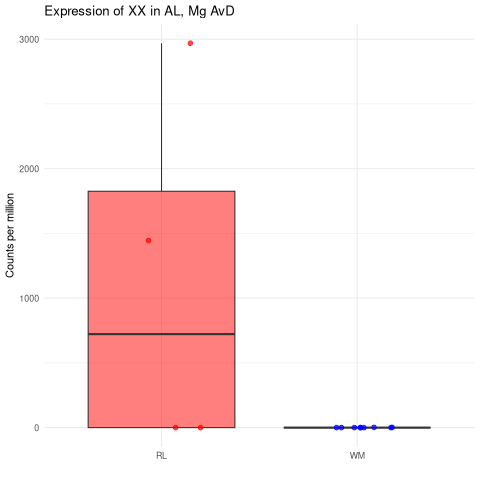

In [92]:
%%R
ggplot(gene_data, aes(x = treatment, y = expression, fill = treatment)) +
  geom_boxplot(alpha = 0.5, outlier.shape = NA) +  # Boxplots without outliers
  geom_jitter(width = 0.2, alpha = 0.7, size = 2, aes(color = treatment)) +  # Individual points
  scale_fill_manual(values = c("WM" = "blue", "RL" = "red")) +  # Custom colors for boxes
  scale_color_manual(values = c("WM" = "blue", "RL" = "red")) +  # Custom colors for points
  labs(
    title = "Expression of XX in AL, Mg AvD",
    x = "",
    y = "Counts per million"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

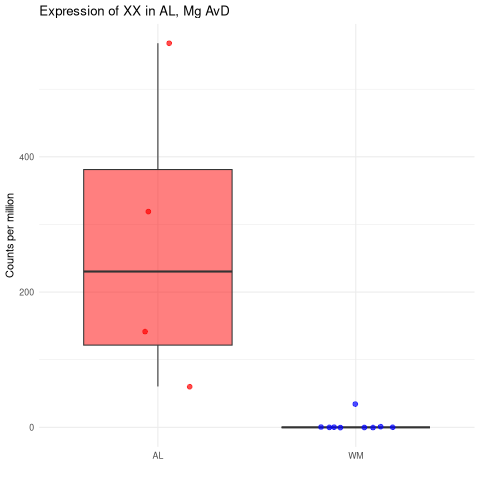

In [93]:
%%R
# Subset data for the specified gene
gene_data <- subset(expr_treatment, gene == "CD163")
gene_data$treatment <- ifelse(gene_data$GroupWM == 1, "WM", "AL")

ggplot(gene_data, aes(x = treatment, y = expression, fill = treatment)) +
  geom_boxplot(alpha = 0.5, outlier.shape = NA) +  # Boxplots without outliers
  geom_jitter(width = 0.2, alpha = 0.7, size = 2, aes(color = treatment)) +  # Individual points
  scale_fill_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for boxes
  scale_color_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for points
  labs(
    title = "Expression of XX in AL, Mg AvD",
    x = "",
    y = "Counts per million"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Try to plot some genes to see if you belive results

In [94]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors
#from gprofiler import gprofiler

In [95]:
from matplotlib import rcParams
from matplotlib import cm, colors

# Create a custom color map using 'PuRd' color map
colors2 = plt.cm.PuRd(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7, 0.8, 20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [96]:
#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [97]:
plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=True, fontsize=12) #color_map=mymap2)
sc.settings.figdir = '/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/Human_scVI_single/figures_MG/'
sc.logging.print_header()

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [98]:
adata= sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/scVI_mdata_MG_working.h5ad')
adata

AnnData object with n_obs × n_vars = 37619 × 29040
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'Cycling cells', 'Cycling_cells', 'Microglia', 'DAM', 'Macrophages', 'BAM', 'Monocytes', 'DCs

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_lesion_type']`


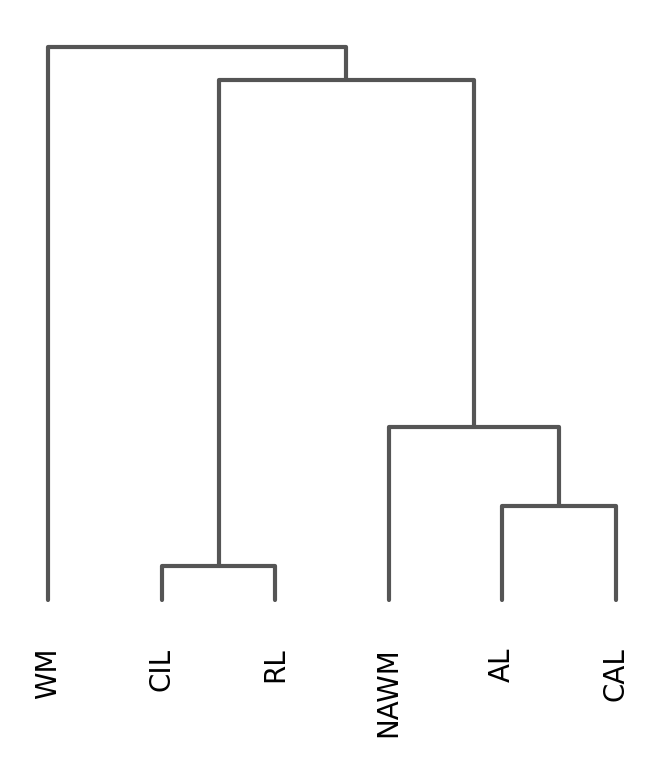

<Axes: >

In [99]:
sc.tl.dendrogram(adata, 'lesion_type')
sc.pl.dendrogram(adata, 'lesion_type')

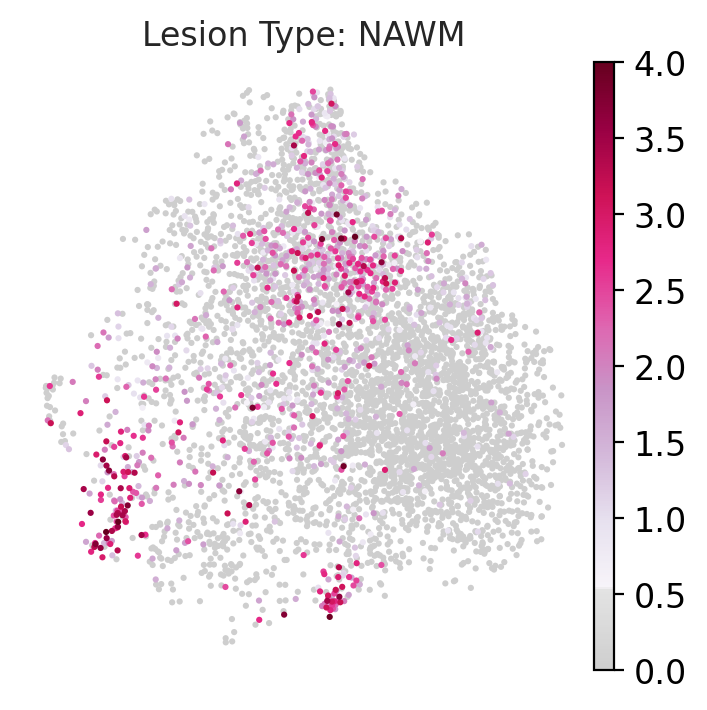

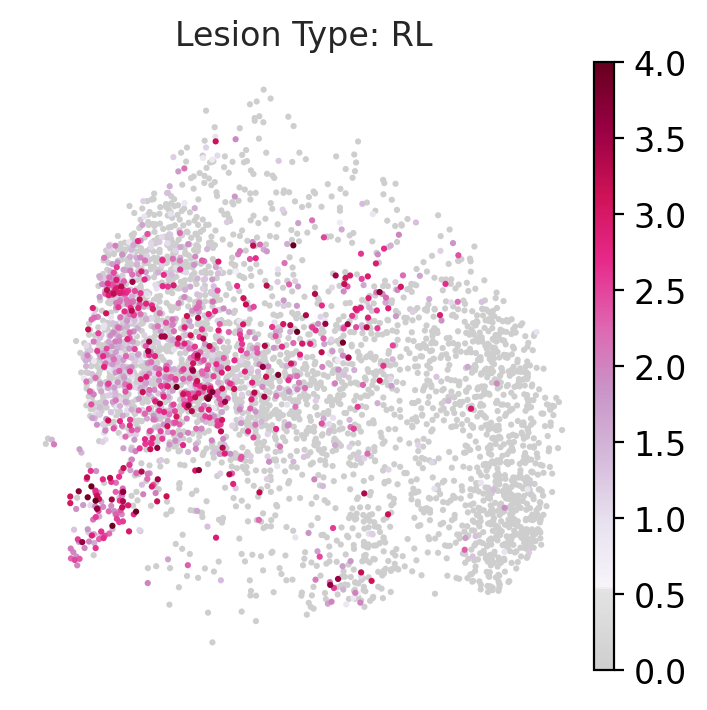

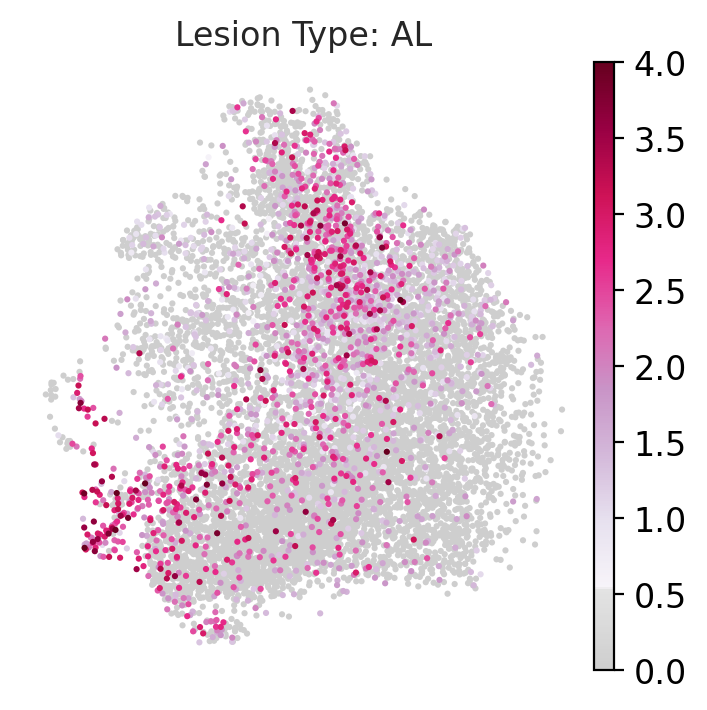

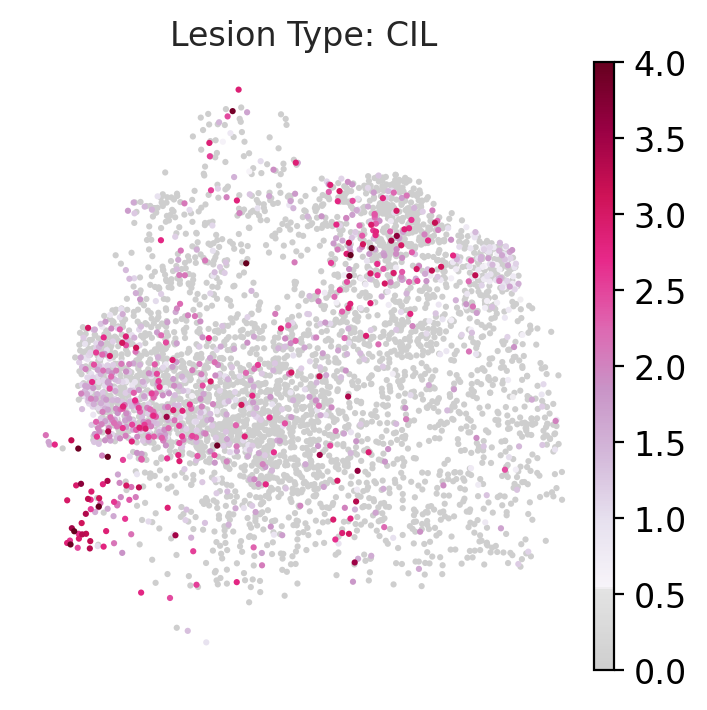

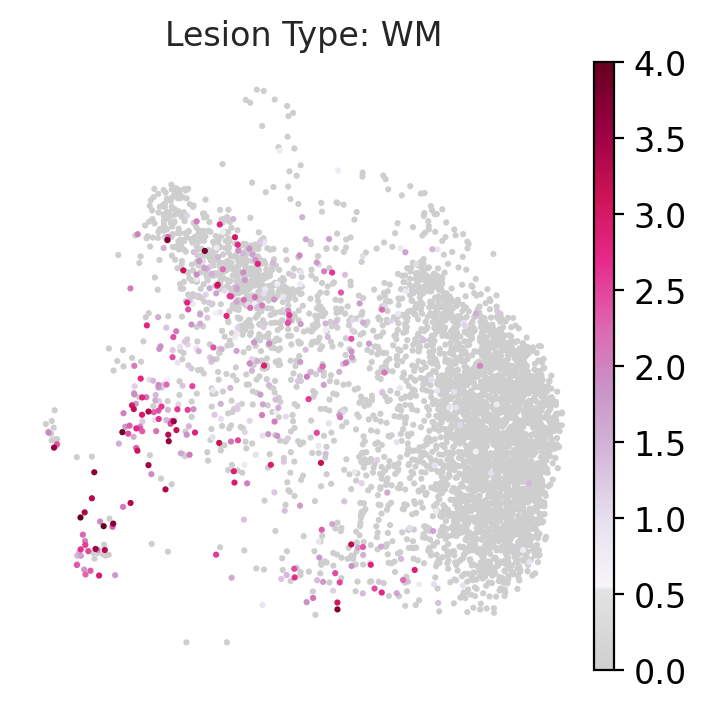

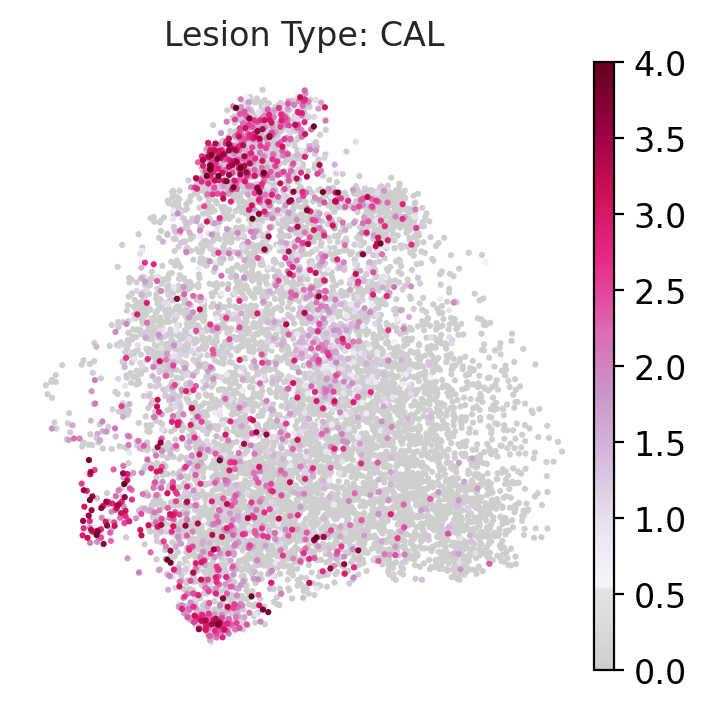

In [100]:
# Specify the gene name you want to include in the filename
gene_name = 'CD163'  # You can change this to any gene name you wish to use

# Loop through each unique value in 'lesion_status'
for lesion_type in set(adata.obs['lesion_type']):
    # Subset the data to only include the current lesion type
    adata_subset = adata[adata.obs['lesion_type'] == lesion_type]
    
    # Generate the UMAP plot for the current subset
    sc.pl.embedding(
        adata_subset, 
        basis='X_umap', 
        color=gene_name,  # Use the gene name
        layer='log1p_norm',
        color_map=mymap, 
        legend_fontweight='normal', 
        s=20, 
        frameon=False,
        vmax=4,
        title=f"Lesion Type: {lesion_type}",
        #save=f'_{gene_name}_lesion_status_{lesion_type}.png'  # Save with gene name and lesion type
    )
    
    # Show the plot
    plt.show()

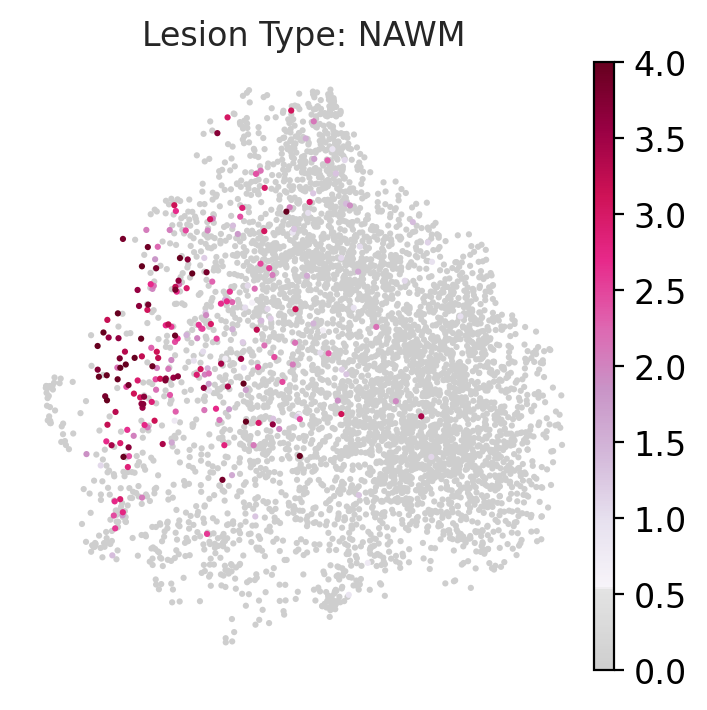

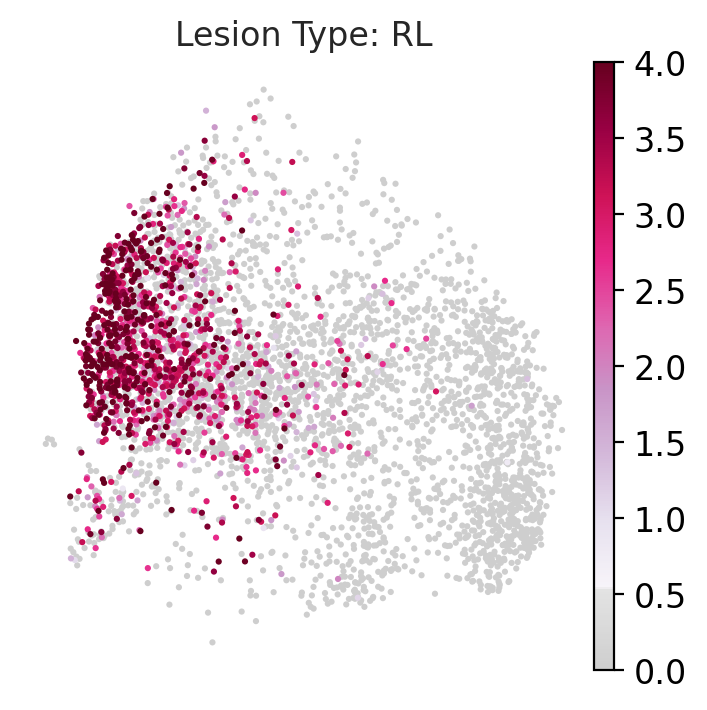

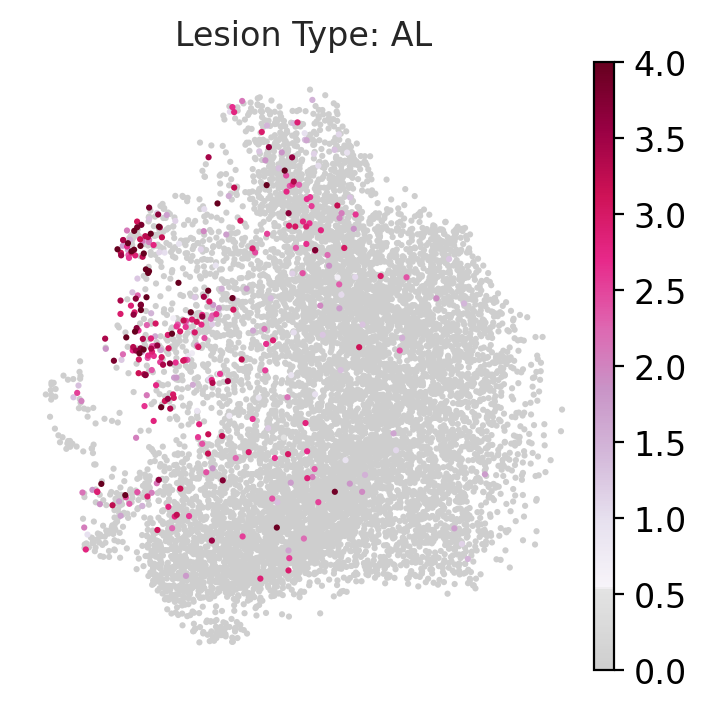

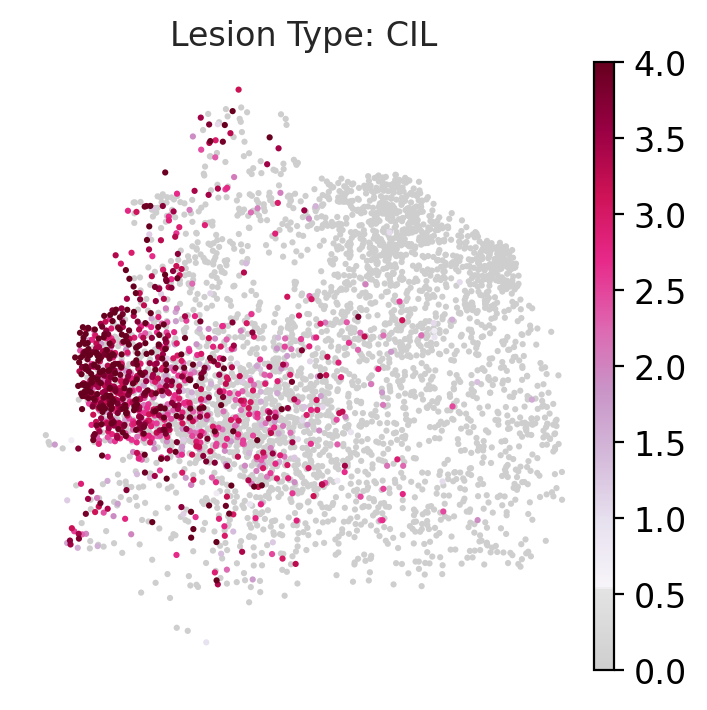

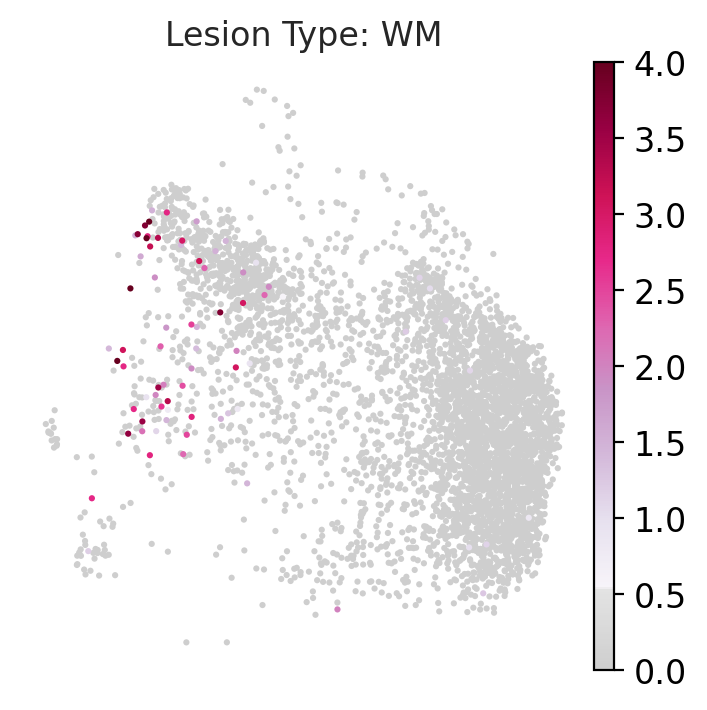

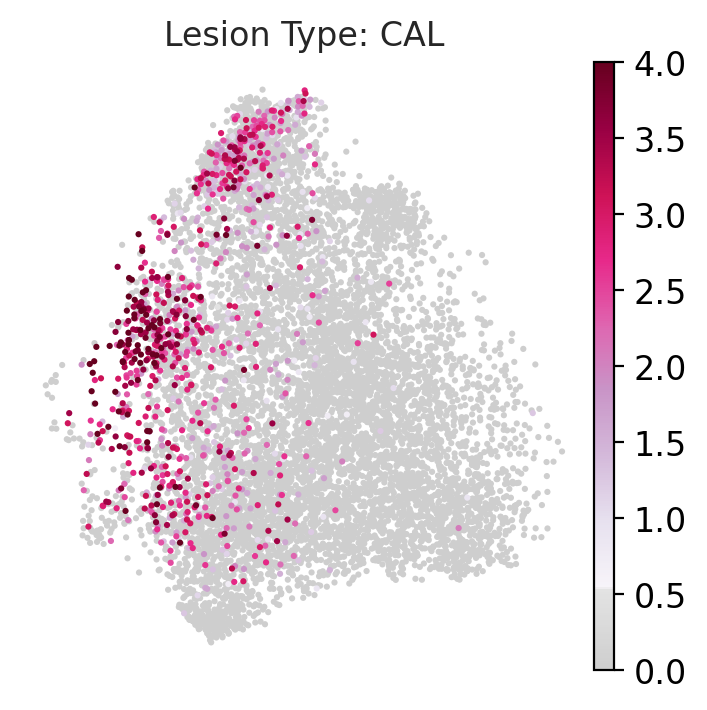

In [115]:
# Specify the gene name you want to include in the filename
gene_name = 'SLC16A10'  # You can change this to any gene name you wish to use

# Loop through each unique value in 'lesion_status'
for lesion_type in set(adata.obs['lesion_type']):
    # Subset the data to only include the current lesion type
    adata_subset = adata[adata.obs['lesion_type'] == lesion_type]
    
    # Generate the UMAP plot for the current subset
    sc.pl.embedding(
        adata_subset, 
        basis='X_umap', 
        color=gene_name,  # Use the gene name
        layer='log1p_norm',
        color_map=mymap, 
        legend_fontweight='normal', 
        s=20, 
        frameon=False,
        vmax=4,
        title=f"Lesion Type: {lesion_type}",
        #save=f'_{gene_name}_lesion_status_{lesion_type}.png'  # Save with gene name and lesion type
    )
    
    # Show the plot
    plt.show()

# Do results overlap with LR pairs?

In [101]:
import liana as li

In [102]:
lr_pairs = li.resource.select_resource('consensus')
lr_pairs.head()

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47


In [103]:
%R -o tt_dream

In [104]:
# Display the first few rows
tt_dream.head()

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std,gene.1
PLXNC1,PLXNC1,-4.977773,4.649426,-16.255692,2.048165e-10,0.000002,14.083097,-6.357685,PLXNC1
EMILIN2,EMILIN2,-4.500667,2.496653,-13.673130,1.970558e-09,0.000008,11.794060,-6.000215,EMILIN2
PTPN22,PTPN22,-4.157709,3.407846,-13.456588,2.422768e-09,0.000008,11.794833,-5.966581,PTPN22
ATP6AP2,ATP6AP2,-1.921152,5.251481,-14.628837,7.633830e-09,0.000019,12.875851,-5.776350,ATP6AP2
TGFBI,TGFBI,-7.448151,3.187120,-12.125474,1.838235e-08,0.000034,3.413571,-5.626574,TGFBI


In [105]:
tt_dream.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
tt_dream.rename(columns={'P.Value': 'Pvalue'}, inplace=True)

In [106]:
# Move row names to a column called 'gene'
tt_dream['gene'] = tt_dream.index

# Reset the index so the gene names become part of the dataframe
tt_dream.reset_index(drop=True, inplace=True)

# Display the updated dataframe
tt_dream.head()

,gene,logFC,AveExpr,t,Pvalue,Padj,B,z.std,gene.1
0,PLXNC1,-4.977773,4.649426,-16.255692,2.048165e-10,0.000002,14.083097,-6.357685,PLXNC1
1,EMILIN2,-4.500667,2.496653,-13.673130,1.970558e-09,0.000008,11.794060,-6.000215,EMILIN2
2,PTPN22,-4.157709,3.407846,-13.456588,2.422768e-09,0.000008,11.794833,-5.966581,PTPN22
3,ATP6AP2,-1.921152,5.251481,-14.628837,7.633830e-09,0.000019,12.875851,-5.776350,ATP6AP2
4,TGFBI,-7.448151,3.187120,-12.125474,1.838235e-08,0.000034,3.413571,-5.626574,TGFBI


In [107]:
sigs = tt_dream[(tt_dream.Padj < 0.05) & (abs(tt_dream.logFC) >= 1)]
sigs.shape

(1329, 9)

In [108]:
lr_pairs.shape

(4624, 2)

In [109]:
sigs.head()

,gene,logFC,AveExpr,t,Pvalue,Padj,B,z.std,gene.1
0,PLXNC1,-4.977773,4.649426,-16.255692,2.048165e-10,0.000002,14.083097,-6.357685,PLXNC1
1,EMILIN2,-4.500667,2.496653,-13.673130,1.970558e-09,0.000008,11.794060,-6.000215,EMILIN2
2,PTPN22,-4.157709,3.407846,-13.456588,2.422768e-09,0.000008,11.794833,-5.966581,PTPN22
3,ATP6AP2,-1.921152,5.251481,-14.628837,7.633830e-09,0.000019,12.875851,-5.776350,ATP6AP2
4,TGFBI,-7.448151,3.187120,-12.125474,1.838235e-08,0.000034,3.413571,-5.626574,TGFBI


In [110]:
ligands = lr_pairs['ligand'].unique()
receptors = lr_pairs['receptor'].unique()

# Combining both ligands and receptors and keeping only unique values
unique_genes = set(ligands).union(set(receptors))

# Checking for overlap with 'sigs' dataframe on the 'gene' column
overlap_genes = sigs[sigs['gene'].isin(unique_genes)]
overlap_genes

,gene,logFC,AveExpr,t,Pvalue,Padj,B,z.std,gene.1
0,PLXNC1,-4.977773,4.649426,-16.255692,2.048165e-10,0.000002,14.083097,-6.357685,PLXNC1
3,ATP6AP2,-1.921152,5.251481,-14.628837,7.633830e-09,0.000019,12.875851,-5.776350,ATP6AP2
23,VEGFA,-6.422415,3.434458,-8.545749,6.815079e-07,0.000279,6.375637,-4.966561,VEGFA
39,VEGFB,-1.660870,5.149558,-8.775997,1.907394e-06,0.000478,6.657433,-4.762996,VEGFB
41,ADM,-7.088885,1.591672,-7.792087,1.990833e-06,0.000478,5.271446,-4.754353,ADM
...,...,...,...,...,...,...,...,...,...
1475,PTPRG,-2.525879,5.162196,-3.498371,6.448059e-03,0.044420,-2.698438,-2.724082,PTPRG
1536,VIPR1,3.921823,2.720952,7.035794,7.116507e-03,0.047079,3.944541,2.691343,VIPR1
1543,ANXA2,-1.932209,2.864407,-3.256515,7.177564e-03,0.047246,-2.798405,-2.688492,ANXA2
1545,HLA-F,-1.473542,4.748782,-3.393769,7.214862e-03,0.047452,-3.009781,-2.686761,HLA-F


In [111]:
# Checking the direction of logFC for the overlapping genes
overlap_genes_direction = overlap_genes[['gene', 'logFC']].copy()

# Determine the direction of logFC
overlap_genes_direction['logFC_direction'] = overlap_genes_direction['logFC'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Displaying the results
overlap_genes_direction

,gene,logFC,logFC_direction
0,PLXNC1,-4.977773,negative
3,ATP6AP2,-1.921152,negative
23,VEGFA,-6.422415,negative
39,VEGFB,-1.660870,negative
41,ADM,-7.088885,negative
...,...,...,...
1475,PTPRG,-2.525879,negative
1536,VIPR1,3.921823,positive
1543,ANXA2,-1.932209,negative
1545,HLA-F,-1.473542,negative


In [112]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 44


,ligand,receptor,logFC_ligand,logFC_receptor
18,FGF2,SDC2,3.712625,-5.819291
16,FGF2,SDC3,3.712625,-1.272291
17,FGF2,FGFR1,3.712625,-3.555537
15,IGF1,IGF2R,3.174177,-1.256199
28,C3,CR1,1.750173,-3.544984
27,C3,C5AR2,1.750173,-1.882717
24,FGF20,FGFR1,1.743093,-3.555537
12,NECTIN3,NECTIN2,1.703735,-1.611150
36,NECTIN3,CADM1,1.703735,-2.012483
31,TCTN1,TMEM67,1.577109,1.763281


In [113]:
sigs_up = tt_dream[(tt_dream.Padj < 0.05) & (tt_dream.logFC <= -1)]
sigs_up.shape

(855, 9)

In [114]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 21


,ligand,receptor,logFC_ligand,logFC_receptor
4,ADAM9,ITGB1,-1.404283,-1.523250
14,C1QA,CD93,-1.685663,-2.434990
18,C1QA,CR1,-1.685663,-3.544984
15,COL5A1,SDC3,-1.796356,-1.272291
0,ANXA2,TLR2,-1.932209,-1.501706
20,IL10,IFNLR1,-2.359176,-2.473920
2,CD14,ITGB1,-3.018148,-1.523250
3,CD14,ITGA4,-3.018148,-5.361318
6,APOE,SDC2,-3.198652,-5.819291
16,APOE,ABCA1,-3.198652,-1.851968


In [ ]:
#sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('./files/LR_pairs_MG_active_AL_CAL_DESIGN_NEW.csv', sep='\t', index=False)